<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/NN-online/blob/main/11text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text generation with an RNN
Recurrent Neural Networks are typically used on __sequences__. Unlike the NNs we have seen so far an RNN takes a __sequence__ of inputs instead of just one. 
The main difference between RRNs and the others is that an RNN contains a __feedback__ loop as shown in the figure below.
The figure also showns an __unrolled__ RNN when the input sequence is of size 4.

![rnn](https://github.com/hikmatfarhat-ndu/NN-online/blob/main/figures/rnn.png?raw=1)

### Import TensorFlow and other libraries

In [3]:
import tensorflow as tf
import numpy as np
import os
import time
from tensorflow.keras.layers import SimpleRNN,SimpleRNNCell,Embedding

As we have seen above an RNN layer is basically a sequence of RNN cells that feed each other. To illustrate we compare the output from a SimpleRNN layer in Keras and the output of two SimpleRNN cells that feed one another

In [2]:
## Initial state
init=tf.zeros_like([[0,0,0,0]],dtype='float32')
print("init shape={}".format(init.shape))
## the input contatins 1 single batch
## of a sequence (size 2) of vectors of dim 3
input=np.array([[1,1,1],[4,4,4]]).astype('float32')
input=input.reshape(1,2,3)
print("input shape={}".format(input.shape))
## Create a "deterministic" RNN so that we always
## get the same output
rnn=SimpleRNN(4,activation='linear', 
       kernel_initializer=tf.keras.initializers.Constant(1), 
        return_sequences=True,
        recurrent_initializer=tf.keras.initializers.Constant(1)
        )
output=rnn(input,initial_state=init)
print(np.squeeze(output.numpy()))


init shape=(1, 4)
input shape=(1, 2, 3)
[[ 3.  3.  3.  3.]
 [24. 24. 24. 24.]]


## return\_sequence=False
If set the RNN will return only the  output of the last step

In [3]:
rnn=SimpleRNN(4,activation='linear', 
       kernel_initializer=tf.keras.initializers.Constant(1), 
        return_sequences=False,
        recurrent_initializer=tf.keras.initializers.Constant(1)
        )
output=rnn(input,initial_state=init)
print(np.squeeze(output.numpy()))



[24. 24. 24. 24.]


### Equivalent network 
Below we build an equivalent network that uses two cells in sequence

In [4]:
seq1=np.array([[1,1,1]]).astype('float32')
seq2=np.array([[4,4,4]]).astype('float32')
### Create a deterministic cell
cell=SimpleRNNCell(4,activation='linear',
        kernel_initializer=tf.keras.initializers.Constant(1),
        recurrent_initializer=tf.keras.initializers.Constant(1)
        )
## output of the first cell
## using seq1 and initialized to init
one=cell(inputs=seq1,states=init)
## output of the second cell
## using seq2 and the output of the previous cell 
two=cell(inputs=seq2,states=one[1])
two=cell(inputs=seq2,states=one[1])
print(np.squeeze(one[0].numpy()))
print(np.squeeze(two[0].numpy()))


[3. 3. 3. 3.]
[24. 24. 24. 24.]


In [5]:
from google.colab import files
file=files.upload()
!mkdir /root/.kaggle
!mv kaggle.json  /root/.kaggle


Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
#!kaggle datasets download -d nzalake52/new-york-times-articles
!kaggle datasets download -d ad6398/bbcnewsarticle
!unzip bbcnewsarticle.zip

  0% 0.00/1.83M [00:00<?, ?B/s]
100% 1.83M/1.83M [00:00<00:00, 127MB/s]
Archive:  bbcnewsarticle.zip
  inflating: bbc-text.csv            


### Python 'set' datastructure



Collect the vocabulary(characters) used in the text

In [7]:
input=['b','a','a','c','a','b','c','a']
inputSet=set(input)
inputSet

{'a', 'b', 'c'}

In [8]:
data_file="bbc-text.csv"
text=open(data_file,encoding='utf8').read()
## A set has unique elements
## therefore set(text)
## contains all characters used in the text
vocab = sorted(set(text))
print(vocab[0:20])
print(vocab[20:40])
print(vocab[40:59])

['\n', ' ', '!', '#', '$', '%', '&', '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4']
['5', '6', '7', '8', '9', ':', ';', '=', '@', '[', ']', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
['i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '£']


Convert the characters to integers


In [9]:
index2char = np.array(vocab)

# Create a dictionary from vocab, with key 'character' and value 'index'
char2index = {u:i for i, u in enumerate(vocab)}

## The encoded text is just a sequence of numbers
encoded_text = np.array([char2index[c] for c in text])
print("number of characters in text={}".format(len(encoded_text)))
nc=10
print("first {} characters".format(nc))
print([index2char[c] for c in encoded_text[0:nc]])
print("first {} encoded characters".format(nc))
encoded_text[0:nc]

number of characters in text=5056090
first 10 characters
['c', 'a', 't', 'e', 'g', 'o', 'r', 'y', ',', 't']
first 10 encoded characters


array([34, 32, 51, 36, 38, 46, 49, 56, 11, 51])

In [10]:
# The maximum length sentence  for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(encoded_text)
char_dataset

<TensorSliceDataset shapes: (), types: tf.int64>

In [11]:
b =char_dataset.take(5)
print("Original Data")
print("------------")
for e in b:
  print(e.numpy(),end= " ")
print("\nBatched data")
c=char_dataset.batch(5,drop_remainder=True)
for e in c.take(1):
  print(e.numpy())

def split_input(batch):
    input_text = batch[:-1]
    target_text = batch[1:]
    return input_text, target_text
print("the final data set")
print("------------------")
d=c.map(split_input)
for e in d.take(1):
  print(e[0].numpy())
  print(e[1].numpy())


Original Data
------------
34 32 51 36 38 
Batched data
[34 32 51 36 38]
the final data set
------------------
[34 32 51 36]
[32 51 36 38]


The `batch` method lets us easily convert these individual characters to sequences of the desired size.

In [12]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
type(sequences)


tensorflow.python.data.ops.dataset_ops.BatchDataset

In [13]:
#print(sequences)
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

BATCH_SIZE = 64
BUFFER_SIZE = 10000

#dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

print(dataset)
for d in dataset.take(1):
    print(d[0][0,3].numpy())
    #print(d[0])
    #print(d[1])

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>
36


## Build The Model

In [14]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024
print(vocab_size)

59


In [15]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.SimpleRNN(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           15104     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (64, None, 1024)          1311744   
_________________________________________________________________
dense (Dense)                (64, None, 59)            60475     
Total params: 1,387,323
Trainable params: 1,387,323
Non-trainable params: 0
_________________________________________________________________


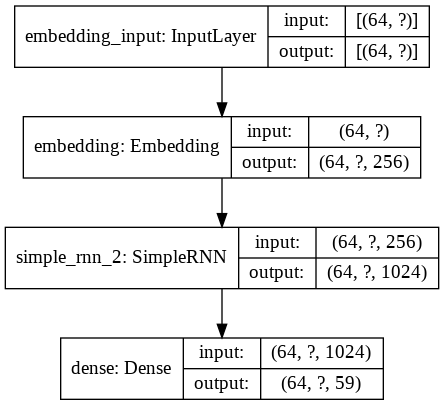

In [16]:
model = build_model(vocab_size=len(vocab),embedding_dim=embedding_dim,rnn_units=rnn_units,batch_size=BATCH_SIZE)
model.summary()
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))    
tf.keras.utils.plot_model(model,show_shapes=True)

### Download the weights of the  pretrained model

In [17]:
!wget https://raw.githubusercontent.com/hikmatfarhat-ndu/NN-online/main/data/rnn-weights.h5

--2020-11-25 09:39:34--  https://raw.githubusercontent.com/hikmatfarhat-ndu/NN-online/main/data/rnn-weights.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5567632 (5.3M) [application/octet-stream]
Saving to: ‘rnn-weights.h5’

rnn-weights.h5      100%[===================>]   5.31M  --.-KB/s    in 0.1s    

2020-11-25 09:39:34 (36.1 MB/s) - ‘rnn-weights.h5’ saved [5567632/5567632]



In [18]:

EPOCHS = 1

weights_file="rnn-weights.h5"
model.load_weights(weights_file)
history = model.fit(dataset, epochs=EPOCHS)
#model.save_weights("weights.h5")

782/782 [==============================] - 43s 55ms/step - loss: 1.3219


## Generate text

Up until now we have used the argmax function to select the category from a vector of logits or probabilities. Argmax, however, is a deterministic function: we always get the same value if the input is the same. In this exercise we would like to __sample__ a probability distribution

In [41]:
logits=np.array([[4,2,1],[5,6,7]],dtype='float32')
samples=tf.random.categorical(logits,num_samples=100).numpy()

unique,count=np.unique(samples[0],return_counts=True)
print(unique,count)
unique,count=np.unique(samples[1],return_counts=True)
print(unique,count)

[0 1 2] [87 10  3]
[0 1 2] [10 27 63]


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            15104     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (1, None, 1024)           1311744   
_________________________________________________________________
dense_1 (Dense)              (1, None, 59)             60475     
Total params: 1,387,323
Trainable params: 1,387,323
Non-trainable params: 0
_________________________________________________________________


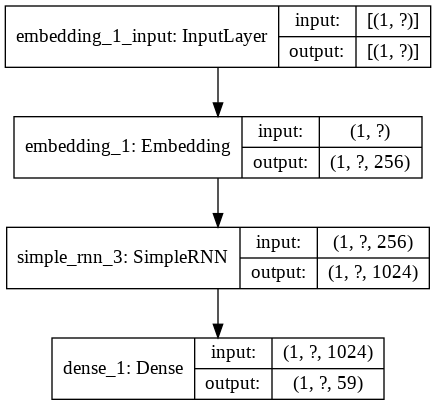

In [19]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(weights_file)
#model.build(tf.TensorShape([1, None]))
model.summary()

### Generating text


In [20]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2index[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(index2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [21]:
print(generate_text(model, start_string=u"skills"))

skillsymock if the street had nominations and service.  the tory leaps  mps up awards  the set out to announcement  chief executive puwed two video office  cuit is expected to address to  discrimulous  but shame at all cheatrek but i m stronglumbia.
entertainment,batter for fully sm ross of identifying the us having  eraf influence in crime up in 1966  which project by 60% his city as the financial and talkman s four-to-figure in pengruggled the state of turn their songs to protect a wolmental important. in the asked at the uk companies in 2000 gets giggs film mp dormounts to reassure have to spobational  llee the hungry a results families.
entertainment,absolutely channelwich. the film games refuse to professive. it s sighweus strong arriver has sets us a mof outstanding over broke protection last season by community if some rijuk before in the portunation have supply group received 45% of claim:  the entail s australia messages for game is that is traffic young service  tv warning ar